<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-10-16 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
sklearn 0.19.0
mlxtend 0.7.0


# Energy reconstruction via ML regression
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [2]:
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn.apionly as sns
import dask
from dask import delayed, multiprocessing
from dask.diagnostics import ProgressBar
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (validation_curve, cross_val_score,
                                     cross_val_predict, GridSearchCV, 
                                     cross_validate, KFold)
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, make_scorer

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

## Define analysis parameters and load simulation

In [40]:
# feature_list = ['lap_cos_zenith', 'log_s125']
# feature_list = ['log_s80', 'log_s125', 'log_s250', 'lap_cos_zenith',
#                 'FractionContainment_Laputop_IceTop', 'NStations']

# feature_list = ['log_s50', 'log_s125', 'log_s250', 'lap_cos_zenith', 'NStations', 'FractionContainment_Laputop_IceTop',
#                 'log_dEdX']
# feature_labels = ['$\mathrm{\log_{10}(S_{50})}$', '$\mathrm{\log_{10}(S_{125})}$', '$\mathrm{\log_{10}(S_{250})}$', 
#                   '$\mathrm{\cos(\\theta)}$', 'NStations', 'IT Conainment', '$\mathrm{\log_{10}(dE/dX)}$']

# config = 'IC86.2012'
config = 'IC79.2010'
num_groups = 2
comp_list = comp.get_comp_list(num_groups=num_groups)
feature_list, feature_labels = comp.get_training_features()
pipeline_str = 'RF_energy_{}'.format(config)
energybins = comp.analysis.get_energybins()

In [41]:
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX']

In [42]:
df_sim_train, df_sim_test = comp.load_sim(config=config, log_energy_min=5.0, log_energy_max=None)

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:157: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_energy'] = np.log10(df['d4r_peak_energy'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:158: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_sigma'] = np.log10(df['d4r_peak_sigma'])


In [43]:
energy_pipeline_dict = comp.load_trained_model(pipeline_str)

In [44]:
energy_pipeline_dict

{'pipeline': Pipeline(memory=None,
      steps=[('classifier', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=2, verbose=0, warm_start=False))]),
 'save_pipeline_code': '/home/jbourbeau/cr-composition/models/save_energy_reco_model.py',
 'sklearn_version': '0.19.0',
 'training_features': ('lap_cos_zenith', 'log_s125', 'log_dEdX')}

In [45]:
energy_pipeline = energy_pipeline_dict['pipeline']

In [46]:
df_sim_train['reco_log_energy'] = energy_pipeline.predict(df_sim_train[feature_list])
df_sim_test['reco_log_energy'] = energy_pipeline.predict(df_sim_test[feature_list])

In [53]:
df_sim_train['reco_log_energy'].min(), df_sim_train['MC_log_energy'].min()

(5.9186237403783517, 5.1365840857113021)

Construct composition masking array for testing and training sets

In [48]:
comp_mask_train, comp_mask_test = {}, {}
for composition in comp_list:
    comp_mask_train[composition] = df_sim_train['comp_group_{}'.format(num_groups)] == composition
    comp_mask_test[composition] = df_sim_test['comp_group_{}'.format(num_groups)] == composition

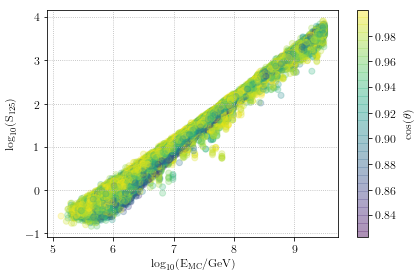

In [49]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['MC_log_energy'], df_sim_train['log_s125'],
                c=df_sim_train['lap_cos_zenith'], alpha=0.25)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         's125_vs_MC_energy_zenith.png')
comp.check_output_dir(s125_vs_MC_energy_outfile)
# plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

## Explore energy reconstruction training features 

$\mathrm{\log_{10}(S_{125})}$ is highly correlated with true energy, and only has a slight composition dependence. This makes it an important training feature in energy reconstruction. 

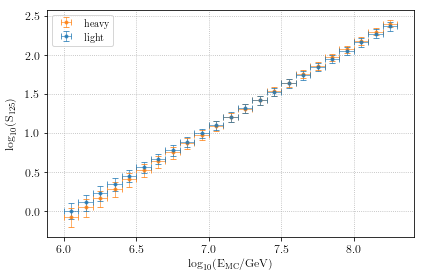

In [52]:
fig, ax = plt.subplots()
for composition in comp_list:
    log_s125 = df_sim_train.loc[comp_mask_train[composition], 'log_s125']
    MC_log_energy = df_sim_train.loc[comp_mask_train[composition], 'MC_log_energy']

    _, bin_medians, error = comp.analysis.get_medians(MC_log_energy, log_s125,
                                                      energybins.log_energy_bins)
    ax.errorbar(energybins.log_energy_midpoints, bin_medians, yerr=error, xerr=0.05, 
                marker='.', ls='None', label=composition, color=color_dict[composition], alpha=0.75)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
ax.legend()
plt.show()

$\mathrm{\log_{10}(dE/dX)}$ too is correlated with true energy, but has the added benefit of being composition dependent as well. This means that an energy reconstruction regressor can also learn composition-dependence of __________.

In [24]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['log_dEdX'],
                                    bins=[np.linspace(6.0, 8.0, 100), np.linspace(-0.5, 3, 100)])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

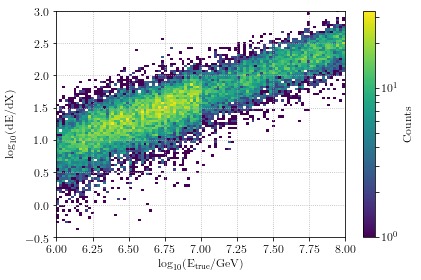

In [25]:
fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(dE/dX)}$')
ax.grid()
plt.colorbar(label='Counts')
# true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          'MC_vs_reco_energy.png')
# comp.check_output_dir(true_vs_reco_energy_outfile)
# plt.savefig(true_vs_reco_energy_outfile)
plt.show()

## Train a RandomForestRegressor to predict shower energy

Define scoring function

In [ ]:
def median_energy_res(log_energy, log_energy_pred):
    return np.median(log_energy-log_energy_pred)
scorer = make_scorer(median_energy_res, greater_is_better=False)

In [ ]:
# parameters = {'max_depth': np.arange(1, 11), 'n_estimators': np.arange(1, 100, 10)}
# gs = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error',
#                   cv=10, n_jobs=10, verbose=2)

# # parameters = {'C': np.linspace(0.01, 1, 10)}
# # gs = GridSearchCV(SVR(), parameters, cv=10, n_jobs=10, verbose=2)

In [ ]:
# gs.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
# gs.best_params_

In [ ]:
# cv_results = pd.DataFrame(gs.cv_results_)

In [6]:
# # clf = gs.best_estimator_
# pipeline_str = 'RF_energy'
# pipeline = comp.get_pipeline(pipeline_str)
# pipeline

Pipeline(memory=None,
     steps=[('classifier', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=2, verbose=0, warm_start=False))])

In [8]:
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2)
# clf = RandomForestRegressor(n_estimators=100, n_jobs=10, random_state=2)

In [9]:
cv_results = cross_validate(pipeline, df_sim_train[feature_list], df_sim_train['MC_log_energy'], 
                            cv=10, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


In [20]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
train_score_mean = np.mean(cv_results['train_score'])
train_score_std = np.std(cv_results['train_score'])
print('Training score = {:0.3f} +/- {:0.2e}'.format(train_score_mean, train_score_std))
test_score_mean = np.mean(cv_results['test_score'])
test_score_std = np.std(cv_results['test_score'])
print('Testing score = {:0.3f} +/- {:0.2e}'.format(test_score_mean, test_score_std))
print('=' * 30)

RandomForestRegressor
Training score = 0.990 +/- 1.24e-04
Testing score = 0.987 +/- 3.78e-04


In [7]:
pipeline = comp.get_pipeline(pipeline_str)
pipeline.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
reco_log_energy = pipeline.predict(df_sim_test[feature_list])

In [8]:
reco_log_energy

array([ 6.47334091,  6.9968418 ,  7.64742117, ...,  7.05748719,
        6.3040016 ,  7.43986531])

1) 0.994364704285
2) 0.00348824930784
3) 0.00214704640735


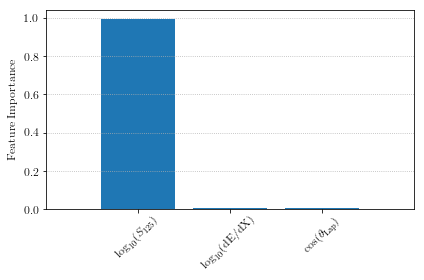

In [71]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

ax.set_ylabel('Feature Importance')
ax.bar(range(num_features), importances[indices], align='center')
plt.xticks(range(num_features), np.array(feature_labels)[indices], rotation=45)
ax.set_xlim([-1, len(feature_list)])
ax.grid(axis='y')
plt.show()

## Model validation

In [17]:
def _cross_validate_comp(df_train, df_test, pipeline_str, 
                                param_name, param_value,
                                feature_list=None, target='comp_target_2', 
                                scoring='r2', num_groups=2, n_splits=10):
    '''Calculates stratified k-fold CV scores for a given hyperparameter value

    Parameters
    ----------
    config : str
        Detector configuration.
    pipeline_str : str
        Name of pipeline to use (e.g. 'BDT', 'RF_energy', etc.).
    param_name : str
        Name of hyperparameter (e.g. 'max_depth', 'learning_rate', etc.).
    param_value : int, float, str
        Value to set hyperparameter to.
    feature_list : list, optional
        List of training feature columns to use (default is to use 
        comptools.get_training_features()). 
    target : str, optional
        Training target to use (default is 'comp_target_2').
    scoring : {'r2', 'mse', 'accuracy'}
        Scoring metric to calculate for each CV fold (default is 'r2'). 
    num_groups : int, optional
        Number of composition class groups to use (default is 2). 
    n_splits : int, optional
        Number of folds to use in (KFold) cross-validation
        (default is 10).

    Returns
    -------
        data_dict : dict
            Return a dictionary with average scores as well as CV errors on those scores.

    '''
    assert scoring in ['accuracy', 'mse', 'r2'], 'Invalid scoring parameter'
    comp_list = comp.get_comp_list(num_groups=num_groups)
    if feature_list is None:
        feature_list, _ = comp.get_training_features()
        
    pipeline = comp.get_pipeline(pipeline_str)
    pipeline.named_steps['classifier'].set_params(**{param_name: param_value})
    # Only run on a single core
    pipeline.named_steps['classifier'].set_params(**{'n_jobs': 1})

    data_dict = {'classifier': pipeline_str, 'param_name': param_name,
                 'param_value': param_value, 'n_splits': n_splits}

    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    ks_pval = defaultdict(list)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
    if scoring == 'mse':
        scorer = mean_squared_error
    elif scoring == 'r2':
        scorer = r2_score
    else:
        scorer = accuracy_score

    for train_index, test_index in kf.split(df_train.values):

        df_train_fold, df_test_fold = df_train.iloc[train_index], df_train.iloc[test_index]

        X_train, y_train = comp.dataframe_functions.dataframe_to_X_y(df_train_fold, feature_list, target=target)
        X_test, y_test = comp.dataframe_functions.dataframe_to_X_y(df_test_fold, feature_list, target=target)

        pipeline = pipeline.fit(X_train, y_train)

        train_pred = pipeline.predict(X_train)
        train_score = scorer(y_train, train_pred)
        train_scores['total'].append(train_score)

        test_pred = pipeline.predict(X_test)
        test_score = scorer(y_test, test_pred)
        test_scores['total'].append(test_score)

        # Get testing/training scores for each composition group
        for composition in comp_list:
            comp_mask_train = df_train_fold['comp_group_{}'.format(num_groups)] == composition
            comp_score_train = scorer(y_train[comp_mask_train], train_pred[comp_mask_train])
            train_scores[composition].append(comp_score_train)

            comp_mask_test = df_test_fold['comp_group_{}'.format(num_groups)] == composition
            comp_score_test = scorer(y_test[comp_mask_test], test_pred[comp_mask_test])
            test_scores[composition].append(comp_score_test)


    for label in comp_list + ['total']:
        data_dict['train_mean_{}'.format(label)] = np.mean(train_scores[label])
        data_dict['train_std_{}'.format(label)] = np.std(train_scores[label])
        data_dict['test_mean_{}'.format(label)] = np.mean(test_scores[label])
        data_dict['test_std_{}'.format(label)] = np.std(test_scores[label])

    return data_dict

In [18]:
def cross_validate_comp(df_train, df_test, pipeline_str, 
                        param_name, param_values,
                        feature_list=None, target='comp_target_2', 
                        scoring='r2', num_groups=2, n_splits=10, n_jobs=1,
                        verbose=False):
    cv_dicts = []
    for param_value in param_values:
        cv_dict = cross_validate_comp_delayed(
                    df_train, df_test, pipeline_str, 
                    param_name, param_value,
                    feature_list=feature_list, target=target, 
                    scoring=scoring, num_groups=num_groups, n_splits=10)
        cv_dicts.append(cv_dict_delayed)

    df_cv = delayed(pd.DataFrame.from_records)(cv_dicts, index='param_value')
    
    get = dask.get if n_jobs == 1 else multiprocessing.get
    if verbose:
        with ProgressBar():
            print('Performing {}-fold CV on {} hyperparameter values ({} fits):'.format(
                n_splits, len(param_values),  n_splits*len(param_values)))
            df_cv = df_cv.compute(get=get, num_works=n_jobs)
#             df_cv = df_cv.compute(num_works=n_jobs)
    else:
        df_cv = df_cv.compute(get=get, num_works=n_jobs)
    
    return df_cv

In [30]:
param_values = np.arange(1, 16, dtype=int)
df_cv_max_depth = cross_validate_comp(
# df_cv_max_depth = comp.analysis.modelevaluation.cross_validate_comp(
                            df_sim_train, df_sim_test, pipeline_str, 
                            param_name='max_depth', param_values=param_values,
                            feature_list=feature_list, target='MC_log_energy', 
                            scoring='mse', num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=10)
#                             verbose=True, n_jobs=min(len(param_values), 20))

Performing 10-fold CV on 15 hyperparameter values (150 fits):
[########################################] | 100% Completed |  9min 51.3s


In [31]:
df_cv_max_depth

,classifier,n_splits,param_name,test_mean_heavy,test_mean_light,test_mean_total,test_std_heavy,test_std_light,test_std_total,train_mean_heavy,train_mean_light,train_mean_total,train_std_heavy,train_std_light,train_std_total
param_value,,,,,,,,,,,,,,,
1,RF_energy,10,max_depth,0.075791,0.083996,0.079991,0.001079,0.000981,0.000692,0.075765,0.083982,0.079977,0.000183,0.000211,0.000182
2,RF_energy,10,max_depth,0.021198,0.023532,0.022393,0.000286,0.000405,0.000239,0.021172,0.023503,0.022367,0.000091,0.000097,0.000090
3,RF_energy,10,max_depth,0.007822,0.008922,0.008386,0.000113,0.000201,0.000097,0.007790,0.008889,0.008353,0.000048,0.000055,0.000050
4,RF_energy,10,max_depth,0.004751,0.005342,0.005054,0.000078,0.000136,0.000049,0.004720,0.005307,0.005021,0.000018,0.000027,0.000020
5,RF_energy,10,max_depth,0.003491,0.004372,0.003942,0.000063,0.000117,0.000039,0.003455,0.004332,0.003905,0.000010,0.000026,0.000016
6,RF_energy,10,max_depth,0.002784,0.003970,0.003392,0.000050,0.000123,0.000052,0.002735,0.003919,0.003342,0.000008,0.000019,0.000012
7,RF_energy,10,max_depth,0.002410,0.003725,0.003084,0.000046,0.000121,0.000054,0.002347,0.003649,0.003014,0.000007,0.000018,0.000011
8,RF_energy,10,max_depth,0.002190,0.003592,0.002908,0.000044,0.000130,0.000059,0.002100,0.003464,0.002799,0.000005,0.000016,0.000009
9,RF_energy,10,max_depth,0.002071,0.003523,0.002815,0.000038,0.000133,0.000061,0.001948,0.003312,0.002647,0.000004,0.000014,0.000008


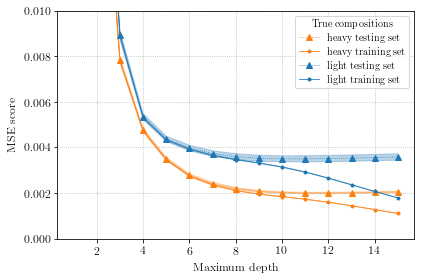

In [32]:
fig, ax = plt.subplots()
# for composition in comp_list + ['total']:
for composition in comp_list:
    # Plot testing curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_max_depth['test_mean_{}'.format(composition)] + df_cv_max_depth['test_std_{}'.format(composition)]
    test_err_low = df_cv_max_depth['test_mean_{}'.format(composition)] - df_cv_max_depth['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_max_depth['train_mean_{}'.format(composition)] + df_cv_max_depth['train_std_{}'.format(composition)]
    train_err_low = df_cv_max_depth['train_mean_{}'.format(composition)] - df_cv_max_depth['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)
    
ax.set_xlabel('Maximum depth')
# ax.set_ylabel('R$^2$ CV score')
ax.set_ylabel('MSE score')
# ax.set_ylim(0.95, 1.0)
ax.set_ylim(0, 0.01)
ax.grid()
ax.legend(title='True compositions')
max_depth_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation', 'validation-curves',
                                 '{}_max_depth_{}.png'.format(pipeline_str, config))
comp.check_output_dir(max_depth_outfile)
plt.savefig(max_depth_outfile)
plt.show()

In [13]:
param_values = np.arange(10, 320, 20, dtype=int)
df_cv_n_estimators = cross_validate_comp(config, pipeline_str, param_name='n_estimators', param_values=param_values,
                            feature_list=feature_list, target='MC_log_energy', 
                            scoring='r2', num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=min(len(param_values), 10))

[########################################] | 100% Completed |  3min  7.5s


In [14]:
df_cv_n_estimators

,classifier,n_splits,param_name,test_mean_heavy,test_mean_light,test_mean_total,test_std_heavy,test_std_light,test_std_total,train_mean_heavy,train_mean_light,train_mean_total,train_std_heavy,train_std_light,train_std_total
param_value,,,,,,,,,,,,,,,
10,RF_energy,10,n_estimators,0.978344,0.978171,0.978301,0.000973,0.000681,0.000599,0.978622,0.978461,0.978573,0.000226,0.000221,0.000212
30,RF_energy,10,n_estimators,0.978685,0.978458,0.978613,0.000884,0.000686,0.000570,0.978974,0.978728,0.978880,0.000215,0.000188,0.000188
50,RF_energy,10,n_estimators,0.978713,0.978481,0.978638,0.000852,0.000718,0.000570,0.979006,0.978747,0.978905,0.000216,0.000177,0.000186
70,RF_energy,10,n_estimators,0.978802,0.978531,0.978707,0.000815,0.000737,0.000566,0.979086,0.978804,0.978973,0.000223,0.000169,0.000186
90,RF_energy,10,n_estimators,0.978791,0.978537,0.978705,0.000836,0.000737,0.000579,0.979075,0.978802,0.978967,0.000194,0.000158,0.000165
110,RF_energy,10,n_estimators,0.978790,0.978544,0.978708,0.000851,0.000745,0.000593,0.979072,0.978804,0.978966,0.000182,0.000146,0.000151
130,RF_energy,10,n_estimators,0.978802,0.978561,0.978723,0.000853,0.000738,0.000589,0.979083,0.978814,0.978977,0.000181,0.000152,0.000155
150,RF_energy,10,n_estimators,0.978801,0.978557,0.978720,0.000855,0.000744,0.000593,0.979083,0.978812,0.978976,0.000183,0.000151,0.000155
170,RF_energy,10,n_estimators,0.978794,0.978557,0.978717,0.000855,0.000751,0.000595,0.979076,0.978809,0.978971,0.000176,0.000138,0.000145


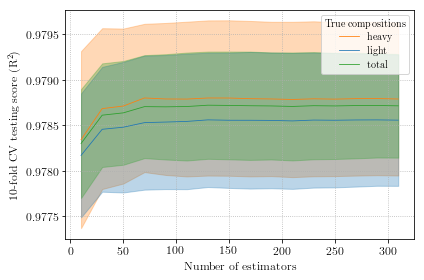

In [15]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    ax.plot(df_cv_n_estimators.index, df_cv_n_estimators['test_mean_{}'.format(composition)], marker='None',
            color=color_dict[composition], label=composition)
    ax.fill_between(df_cv_n_estimators.index,
                    df_cv_n_estimators['test_mean_{}'.format(composition)] + df_cv_n_estimators['test_std_{}'.format(composition)],
                    df_cv_n_estimators['test_mean_{}'.format(composition)] - df_cv_n_estimators['test_std_{}'.format(composition)],
                    color=color_dict[composition], alpha=0.3)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('10-fold CV testing score (R$^2$)')
# ax.set_ylabel('MSE testing score')
# ax.set_ylim(0, 0.01)
ax.grid()
ax.legend(title='True compositions')
plt.show()

## Energy reconstruction performance plots

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


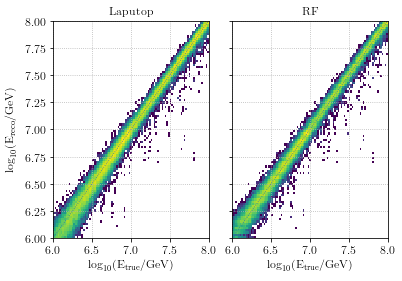

In [9]:
h_lap, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['lap_log_energy'],
                                        bins=np.linspace(6.0, 8.0, 100))
h_lap = np.rot90(h_lap)
h_lap = np.flipud(h_lap)

h_reco, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                         bins=np.linspace(6.0, 8.0, 100))
h_reco = np.rot90(h_reco)
h_reco = np.flipud(h_reco)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

gs = gridspec.GridSpec(1, 2, wspace=0.15)
ax_lap = plt.subplot(gs[0])
# ax_reco = plt.subplot(gs[1])
ax_reco = plt.subplot(gs[1], sharey=ax_lap)

# fig, ax = plt.subplots()
for h, ax, title in zip([h_lap, h_reco], [ax_lap, ax_reco], ['Laputop', 'RF']):
    ax.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none',
              aspect='auto')
    ax.plot([6, 8], [6, 8], marker='None', ls=':')
    # ax.set_xlim([6.4, 8.0])
    # ax.set_ylim([6.4, 8.0])
    ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
#     ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_title(title)
    ax.grid()
    
ax_reco.tick_params(labelleft='off')
ax_lap.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')

# plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy_{}.png'.format(config))
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

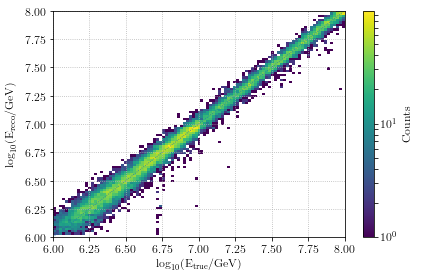

In [26]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                    bins=np.linspace(6.0, 8.0, 100))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
ax.plot([6, 8], [6, 8], marker='None', ls=':')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy.png')
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

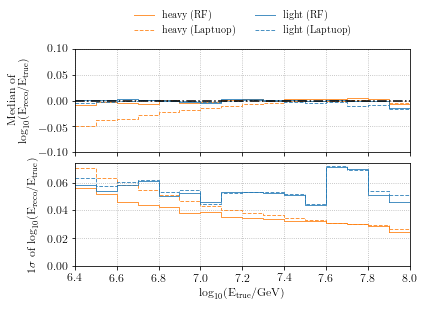

In [10]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
#     comp_mask = df_sim_test['MC_comp_class'] == composition
    
    # Plot RF reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laptuop)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laptuop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.45),# vertical 
                 ncol=len(comp_list), fancybox=False)

ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

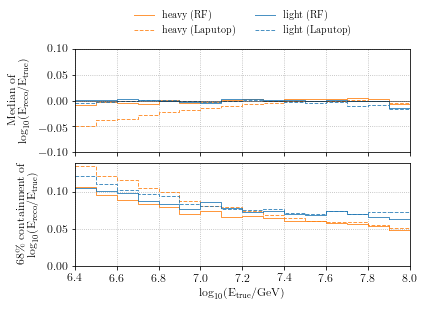

In [11]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
#     comp_mask = df_sim_test['MC_comp_class'] == composition
    
    # Plot RF reco energy 
    _, medians, error = comp.analysis.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    _, medians, error = comp.analysis.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laputop)', ax=ax1)

    plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laputop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-', color='k', lw=0.5)

ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
#                                  1.25),# vertical 
                                 1.45),# vertical 
                 ncol=len(comp_list), fancybox=False)

ax2.set_ylabel('68\% containment of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_containment_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

KeyError: 'intermediate'

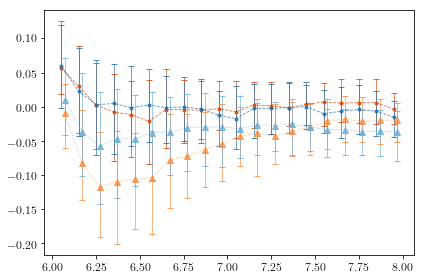

In [29]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']


fig, ax = plt.subplots()
res_color_dict = {'light': sns.color_palette('Blues', 3).as_hex()[::-1],
                  'heavy': sns.color_palette('Oranges', 3).as_hex()[::-1]}
for composition in comp_list:
    comp_mask = df_sim_test['MC_comp_class'] == composition
    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', ls='--', 
                color=res_color_dict[composition][0], alpha=0.8, label=composition + ' (RF)')

    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            lap_energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers + 0.02, bin_medians, yerr=error, marker='^', ls=':', 
                color=res_color_dict[composition][1], alpha=0.8, label=composition + ' (Laputop)')
    
ax.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
# ax.set_ylim(-0.1, 0.1)
ax.grid()
# ax.legend()
leg = ax.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.25),# vertical 
                 ncol=len(comp_list), fancybox=False)

# ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
# ax2.set_ylim(0)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
# ax2.grid()

# ax.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_comparison.png')
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

In [ ]:
def plot_validation_curve(validation_dict, param_name, ylime=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(validation_dict['range'], validation_dict['train_mean'], label="Training score",
             color='C0')
    ax.fill_between(validation_dict['range'], validation_dict['train_mean'] - validation_dict['train_std'],
                     validation_dict['train_mean'] + validation_dict['train_std'], alpha=0.2,
                     color='C0')
    
    ax.plot(validation_dict['range'], validation_dict['test_mean'], label="Cross-validation score",
                 color='C2')
    ax.fill_between(validation_dict['range'], validation_dict['test_mean'] - validation_dict['test_std'],
                     validation_dict['test_mean'] + validation_dict['test_std'], alpha=0.2,
                     color='C2')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Median energy resolution')
    ax.grid()
    ax.legend()
    
    return ax

## Validation curve for maximum tree depth

In [ ]:
max_depth_validation = {}
max_depth_validation['range'] = np.arange(1, 11)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='max_depth', param_range=max_depth_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
max_depth_validation['train_mean'] = np.mean(train_scores, axis=1)
max_depth_validation['train_std'] = np.std(train_scores, axis=1)
max_depth_validation['test_mean'] = np.mean(test_scores, axis=1)
max_depth_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(max_depth_validation, 'Maximum tree depth', ax=ax)
plt.show()

In [ ]:
max_depth_validation

In [ ]:
clf.set_params(max_depth=20)

In [ ]:
n_estimators_validation = {}
n_estimators_validation['range'] = np.arange(10, 500, 100)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='n_estimators', param_range=n_estimators_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
n_estimators_validation['train_mean'] = np.mean(train_scores, axis=1)
n_estimators_validation['train_std'] = np.std(train_scores, axis=1)
n_estimators_validation['test_mean'] = np.mean(test_scores, axis=1)
n_estimators_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
n_estimators_validation

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(n_estimators_validation, 'Number of iterations', ax=ax)
plt.show()

In [ ]:
clf.set_params(n_estimators=200)

In [ ]:
clf = clf.fit(sim_train.X, sim_train.y)
train_pred = clf.predict(sim_train.X)
# train_acc = mean_squared_error(sim_train.y, train_pred)
train_score = median_energy_res(sim_train.y, train_pred)

test_pred = clf.predict(sim_test.X)
# test_acc = mean_squared_error(sim_test.y, test_pred)
test_score = median_energy_res(sim_test.y, test_pred)
print('Testing score: {}'.format(test_score))
print('Training score: {}'.format(train_score))

In [ ]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [ ]:
light_mask = sim_test.comp == 'light'
heavy_mask = sim_test.comp == 'heavy'

In [ ]:
energy_resolution = np.log10(test_pred/sim_test.y)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[light_mask],
                                                                           energy_resolution[light_mask],
                                                                           np.log10(energy_bins))
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[heavy_mask],
                                                                           energy_resolution[heavy_mask],
                                                                           np.log10(energy_bins))

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.log10(energy_midpoints), bin_medians_light, yerr=error_light,
            marker='.', ls='None', label='light')
ax.errorbar(np.log10(energy_midpoints), bin_medians_heavy, yerr=error_heavy,
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.3, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()